In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [ ]:
th = pd.read_csv('th-public.csv')
annonimized = pd.read_csv('annonimized.csv')

print("Size of qt dataset:", th.shape)
print("Size of annonimized dataset:", annonimized.shape)


Size of qt dataset: (761, 2)
Size of annonimized dataset: (295198, 11)


In [ ]:

print(f"Columns: {annonimized.columns.tolist()}")

print(f"\nNumber of unique students: {annonimized['concat(\'it001\', username)'].nunique()}")
print(f"Number of unique assignments: {annonimized['concat(\'it001\',`assignment_id`)'].nunique()}")
print(f"Number of unique problems: {annonimized['concat(\'it001\',`problem_id`)'].nunique()}")

Columns: ["concat('it001',`assignment_id`)", "concat('it001',`problem_id`)", "concat('it001', username)", 'is_final', 'status', 'pre_score', 'coefficient', "concat('it001',`language_id`)", 'created_at', 'updated_at', 'judgement']

Number of unique students: 1489
Number of unique assignments: 203
Number of unique problems: 469


In [ ]:
import json

annonimized_extracted = annonimized[[
    "concat('it001',`assignment_id`)",
    "concat('it001',`problem_id`)",
    "concat('it001', username)",
    "is_final",
    "status",
    "coefficient",
    "pre_score",
    "created_at",
    "updated_at",
    "judgement"
]].copy()

annonimized_extracted.columns = [
    "assignment_id",
    "problem_id",
    "student",
    "is_final",
    "status",
    "late_coef",
    "score_percent",
    "submit_time",
    "grade_time",
    "judgement"
]

annonimized_extracted = annonimized_extracted[[
    "assignment_id",
    "problem_id",
    "student",
    "is_final",
    "status",
    "late_coef",
    "score_percent",
]]

annonimized_extracted

,assignment_id,problem_id,student,is_final,status,late_coef,score_percent
0,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,100,0
1,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,100,0
2,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,100,10000
3,90ce27571176d87961b565d5ef4b3de33ede04ac,bf96fbdc5f499538c3e2bfbec5779c8a14b0a9ff,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,100,10000
4,90ce27571176d87961b565d5ef4b3de33ede04ac,7a6e5ca470ff47c3b5048f240c4738de71010c78,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,100,10000
...,...,...,...,...,...,...,...
295193,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,388516cbf597351226be1bdbe5ef30b9dcef570f,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,100,10000
295194,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,0,Compilation Error,100,0
295195,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,100,10000
295196,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,8c0f8dd4ff55e1609f733e043ac5e88b1dde6e7c,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,100,10000


In [97]:
student_stats = annonimized_extracted.groupby('student').agg(
    num_submissions=('student', 'count'),  # Tổng số lần nộp bài
    num_score_100=('score_percent', lambda x: (x == 10000).sum()),  # Số lần đạt 100% testcase
    num_unique_problems=('problem_id', 'nunique'),  # Số bài tập unique đã làm
    num_unique_assignments=('assignment_id', 'nunique'),  # Số assignment unique đã làm
    avg_score_percent=('score_percent', 'mean'),  # Điểm trung bình các lần nộp
    avg_late_coef=('late_coef', 'mean'),  # Hệ số trễ trung bình
    num_final_submissions=('is_final', lambda x: (x == 1).sum()),  # Số lần nộp tính điểm
    total_status_ok=('status', lambda x: (x == "SCORE").sum()),  # Số lần code chạy được
).reset_index()

# Tính thêm các tỷ lệ
student_stats['ratio_score_100'] = student_stats['num_score_100'] / student_stats['num_submissions']
student_stats['ratio_final_submissions'] = student_stats['num_final_submissions'] / student_stats['num_submissions']
student_stats['ratio_status_ok'] = student_stats['total_status_ok'] / student_stats['num_submissions']
student_stats['avg_submissions_per_problem'] = student_stats['num_submissions'] / student_stats['num_unique_problems']

student_stats

,student,num_submissions,num_score_100,num_unique_problems,num_unique_assignments,avg_score_percent,avg_late_coef,num_final_submissions,total_status_ok,ratio_score_100,ratio_final_submissions,ratio_status_ok,avg_submissions_per_problem
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,147,54,46,7,5504.149660,100.000000,46,119,0.367347,0.312925,0.809524,3.195652
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,259,85,78,9,5488.552124,100.000000,78,209,0.328185,0.301158,0.806950,3.320513
2,01122b3ef7e59b84189e65985305f575d6bdf83c,195,59,66,7,5973.753846,100.000000,67,175,0.302564,0.343590,0.897436,2.954545
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,100,52,47,4,5952.760000,100.000000,47,76,0.520000,0.470000,0.760000,2.127660
4,013de369c439ab0ead8aa7da64423aa395a8be39,107,59,52,8,6474.448598,97.196262,66,94,0.551402,0.616822,0.878505,2.057692
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,74,40,34,9,5581.081081,100.000000,34,71,0.540541,0.459459,0.959459,2.176471
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,260,80,77,6,6204.557692,100.000000,78,216,0.307692,0.300000,0.830769,3.376623
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,437,105,100,6,4998.466819,100.000000,103,360,0.240275,0.235698,0.823799,4.370000
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,94,30,34,7,4343.329787,100.000000,34,74,0.319149,0.361702,0.787234,2.764706


In [98]:
th['TH'] = pd.to_numeric(th['TH'], errors='coerce')
th

,hash,TH
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,5.0
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,8.5
2,01122b3ef7e59b84189e65985305f575d6bdf83c,7.0
3,013de369c439ab0ead8aa7da64423aa395a8be39,10.0
4,014c59c6433fd764a0b08de6ffeb757eaf60aa73,6.0
...,...,...
756,840d07858c03f80f4695056e2cc7d0c474b83a25,6.0
757,844f5db2e7e31ae51eba025480679ed7e4708ac6,8.5
758,845acd04a77b3d1b623f255d9f9f8eae90892dab,5.5
759,8460eaaf887a6289fb156f7562fb739ba8e9629e,10.0


In [ ]:

student_stats_merged = student_stats.merge(th[['hash', 'TH']], how='left', left_on='student', right_on='hash')
student_stats_merged = student_stats_merged.drop(columns=['hash'])

student_stats_merged

,student,num_submissions,num_score_100,num_unique_problems,num_unique_assignments,avg_score_percent,avg_late_coef,num_final_submissions,total_status_ok,ratio_score_100,ratio_final_submissions,ratio_status_ok,avg_submissions_per_problem,TH
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,147,54,46,7,5504.149660,100.000000,46,119,0.367347,0.312925,0.809524,3.195652,5.0
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,259,85,78,9,5488.552124,100.000000,78,209,0.328185,0.301158,0.806950,3.320513,8.5
2,01122b3ef7e59b84189e65985305f575d6bdf83c,195,59,66,7,5973.753846,100.000000,67,175,0.302564,0.343590,0.897436,2.954545,7.0
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,100,52,47,4,5952.760000,100.000000,47,76,0.520000,0.470000,0.760000,2.127660,NaN
4,013de369c439ab0ead8aa7da64423aa395a8be39,107,59,52,8,6474.448598,97.196262,66,94,0.551402,0.616822,0.878505,2.057692,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,74,40,34,9,5581.081081,100.000000,34,71,0.540541,0.459459,0.959459,2.176471,NaN
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,260,80,77,6,6204.557692,100.000000,78,216,0.307692,0.300000,0.830769,3.376623,NaN
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,437,105,100,6,4998.466819,100.000000,103,360,0.240275,0.235698,0.823799,4.370000,NaN
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,94,30,34,7,4343.329787,100.000000,34,74,0.319149,0.361702,0.787234,2.764706,NaN


In [ ]:

graded = student_stats_merged[student_stats_merged['TH'].notnull()].copy()
ungraded = student_stats_merged[student_stats_merged['TH'].isnull()].copy()

In [101]:
graded

,student,num_submissions,num_score_100,num_unique_problems,num_unique_assignments,avg_score_percent,avg_late_coef,num_final_submissions,total_status_ok,ratio_score_100,ratio_final_submissions,ratio_status_ok,avg_submissions_per_problem,TH
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,147,54,46,7,5504.149660,100.000000,46,119,0.367347,0.312925,0.809524,3.195652,5.0
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,259,85,78,9,5488.552124,100.000000,78,209,0.328185,0.301158,0.806950,3.320513,8.5
2,01122b3ef7e59b84189e65985305f575d6bdf83c,195,59,66,7,5973.753846,100.000000,67,175,0.302564,0.343590,0.897436,2.954545,7.0
4,013de369c439ab0ead8aa7da64423aa395a8be39,107,59,52,8,6474.448598,97.196262,66,94,0.551402,0.616822,0.878505,2.057692,10.0
5,014c59c6433fd764a0b08de6ffeb757eaf60aa73,199,79,90,9,5240.025126,100.000000,90,154,0.396985,0.452261,0.773869,2.211111,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,840d07858c03f80f4695056e2cc7d0c474b83a25,111,41,43,6,5171.639640,100.000000,44,81,0.369369,0.396396,0.729730,2.581395,6.0
797,844f5db2e7e31ae51eba025480679ed7e4708ac6,357,108,104,17,4785.224090,100.000000,104,254,0.302521,0.291317,0.711485,3.432692,8.5
798,845acd04a77b3d1b623f255d9f9f8eae90892dab,155,47,52,8,4247.296774,100.000000,53,117,0.303226,0.341935,0.754839,2.980769,5.5
799,8460eaaf887a6289fb156f7562fb739ba8e9629e,557,113,114,12,4278.605027,100.000000,115,416,0.202873,0.206463,0.746858,4.885965,10.0


In [102]:
ungraded

,student,num_submissions,num_score_100,num_unique_problems,num_unique_assignments,avg_score_percent,avg_late_coef,num_final_submissions,total_status_ok,ratio_score_100,ratio_final_submissions,ratio_status_ok,avg_submissions_per_problem,TH
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,100,52,47,4,5952.760000,100.0,47,76,0.520000,0.470000,0.760000,2.127660,NaN
20,035f97702f2c01d26ab1fae8f39ea2f98a0caa3c,144,52,50,4,5035.763889,100.0,50,103,0.361111,0.347222,0.715278,2.880000,NaN
40,06024da8147b5cf6105beb4c403f67cf1ff0aea1,8,5,5,1,6778.750000,100.0,5,8,0.625000,0.625000,1.000000,1.600000,NaN
68,0aaebc88f6106684d6993c156104c1ef36cf94e0,192,53,50,4,4065.369792,100.0,50,149,0.276042,0.260417,0.776042,3.840000,NaN
80,0bf111a9caedf02804f6991792490e63bc21058a,199,79,65,6,6355.753769,100.0,82,176,0.396985,0.412060,0.884422,3.061538,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,74,40,34,9,5581.081081,100.0,34,71,0.540541,0.459459,0.959459,2.176471,NaN
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,260,80,77,6,6204.557692,100.0,78,216,0.307692,0.300000,0.830769,3.376623,NaN
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,437,105,100,6,4998.466819,100.0,103,360,0.240275,0.235698,0.823799,4.370000,NaN
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,94,30,34,7,4343.329787,100.0,34,74,0.319149,0.361702,0.787234,2.764706,NaN


In [103]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

Model score (R^2): 0.3332287497334854


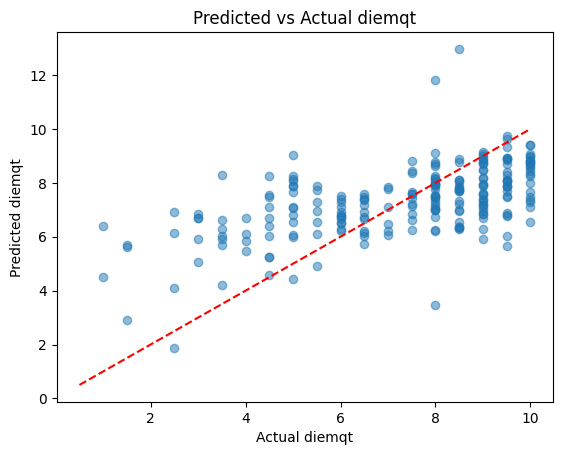

In [ ]:

X = graded.drop(columns=['student', 'TH'])
y = graded['TH'].astype(float)  # Convert diemqt to float


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


lr = LinearRegression()
lr.fit(X_train, y_train)


print("Model score (R^2):", lr.score(X_test, y_test))
plt.scatter(y_test, lr.predict(X_test), alpha=0.5)
plt.xlabel('Actual diemqt')
plt.ylabel('Predicted diemqt')
plt.title('Predicted vs Actual diemqt')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--') 
plt.show()


In [ ]:
X_predict = scaler.transform(ungraded.drop(columns=['student', 'TH']))

predictions = lr.predict(X_predict)

predict_ungraded = ungraded.copy()
predict_ungraded['TH'] = predictions

predict_ungraded

,student,num_submissions,num_score_100,num_unique_problems,num_unique_assignments,avg_score_percent,avg_late_coef,num_final_submissions,total_status_ok,ratio_score_100,ratio_final_submissions,ratio_status_ok,avg_submissions_per_problem,TH
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,100,52,47,4,5952.760000,100.0,47,76,0.520000,0.470000,0.760000,2.127660,6.184603
20,035f97702f2c01d26ab1fae8f39ea2f98a0caa3c,144,52,50,4,5035.763889,100.0,50,103,0.361111,0.347222,0.715278,2.880000,6.327117
40,06024da8147b5cf6105beb4c403f67cf1ff0aea1,8,5,5,1,6778.750000,100.0,5,8,0.625000,0.625000,1.000000,1.600000,6.331900
68,0aaebc88f6106684d6993c156104c1ef36cf94e0,192,53,50,4,4065.369792,100.0,50,149,0.276042,0.260417,0.776042,3.840000,6.875786
80,0bf111a9caedf02804f6991792490e63bc21058a,199,79,65,6,6355.753769,100.0,82,176,0.396985,0.412060,0.884422,3.061538,8.252832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,74,40,34,9,5581.081081,100.0,34,71,0.540541,0.459459,0.959459,2.176471,7.126178
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,260,80,77,6,6204.557692,100.0,78,216,0.307692,0.300000,0.830769,3.376623,7.912304
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,437,105,100,6,4998.466819,100.0,103,360,0.240275,0.235698,0.823799,4.370000,8.632493
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,94,30,34,7,4343.329787,100.0,34,74,0.319149,0.361702,0.787234,2.764706,6.510772


In [ ]:

predict_ungraded = predict_ungraded[['student', 'TH']]

predict_ungraded.to_csv('predicted_th.csv', index=False)